# inspect single model


In [1]:
from sklearn.metrics import adjusted_rand_score
from matplotlib import pyplot as plt
from scipy.special import softmax
from itertools import product
import numpy as np
from utils import *
from model import *
import time
import seaborn as sns
sns.set_context('talk')

%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### mse 0 
gs0317-0-mse0.047-acc-concentration_1.525-stickiness_wi_1.084-stickiness_bt_1.084-sparsity_0.153-pvar_0.000-lrate_1.000-lratep_1.000-decay_rate_1.000-beta2_0.000-skipt1_1.000-ppd_allsch_0.000.png

In [2]:
## topmse
schargs_mse0 ={
  'concentration': 1.525,
  'stickiness_wi': 1.084,
  'stickiness_bt': 1.084,
  'sparsity': 0.153
}

In [3]:
schargs_ = schargs_mse0
schargs = {
   'concentration':schargs_['concentration'],
   'stickiness_wi':schargs_['stickiness_wi'],
   'stickiness_bt':schargs_['stickiness_bt'],
   'sparsity':schargs_['sparsity'],
   'pvar': 0,
   'lrate':1,
   'lratep':1,
   'decay_rate':1,
}
semargs = {
  'beta2':False,
  'skipt1':True,
  'ppd_allsch':False
}


In [4]:
taskargs = {
  'condition':'blocked',
  'n_train':160,
  'n_test':40
}
args = {
    'sem':semargs,
    'sch':schargs,
    'exp':taskargs
}
param_str = "-".join(["%s_%.3f"%(i,j) for i,j in schargs.items()])
param_str += "-"+"-".join(["%s_%.3f"%(i,j) for i,j in semargs.items()])
param_str

'concentration_1.525-stickiness_wi_1.084-stickiness_bt_1.084-sparsity_0.153-pvar_0.000-lrate_1.000-lratep_1.000-decay_rate_1.000-beta2_0.000-skipt1_1.000-ppd_allsch_0.000'

In [5]:
## timestamp and dir for saving
import os
tstamp = time.perf_counter_ns()
figdir = 'figures/single_model_nb/%s-%i/'%(param_str,tstamp)
os.makedirs(figdir)

### main

In [6]:
ns = 50
L = []
condL = ['blocked','interleaved',
         'early','middle','late'
        ]
exp_batch_data = run_batch_exp_curr(ns,args,condL) # [curr,seeds,{data}]


# accuracy analyses

In [7]:
## accuracy
batch_acc = unpack_acc(exp_batch_data,mean_over_tsteps=False) # curr,seeds,tsteps,trials
mean_acc = batch_acc.mean((1,2))
test_acc = mean_acc[:,-40:].mean(1) 
test_acc

array([0.93857363, 0.66155049, 0.90951455, 0.67455294, 0.68707341])

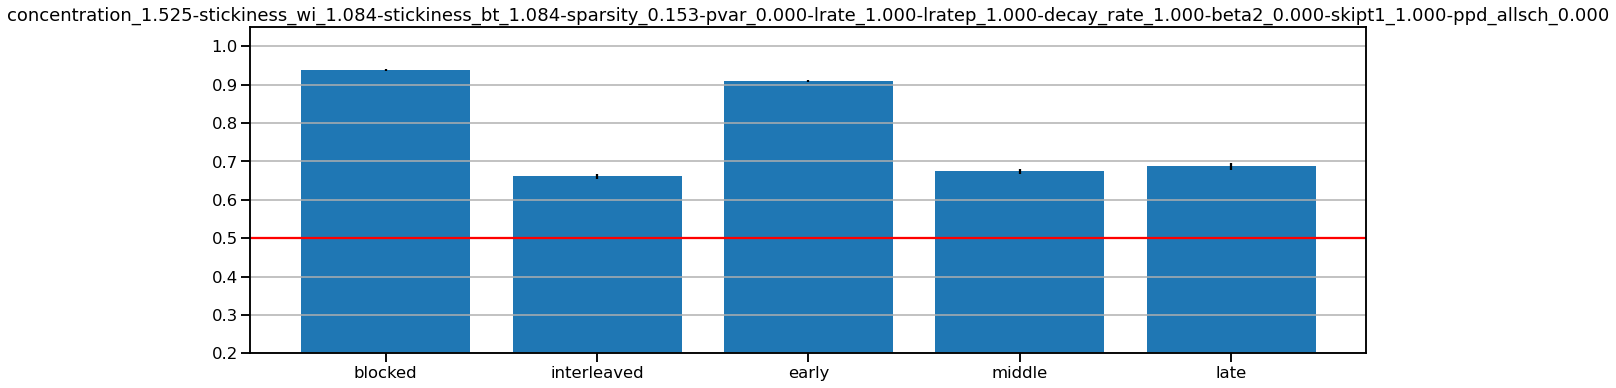

In [8]:
plt.figure(figsize=(20,6))
M = mean_acc[:,-40:].mean(1)
S = mean_acc[:,-40:].std(1)/np.sqrt(ns)
plt.bar(condL,test_acc,yerr=S)
plt.ylim(0.2,1.05)
plt.axhline(0.5,c='r')
plt.title(param_str)
plt.grid(True,axis='y')
plt.savefig(figdir+'Mtestacc.png')

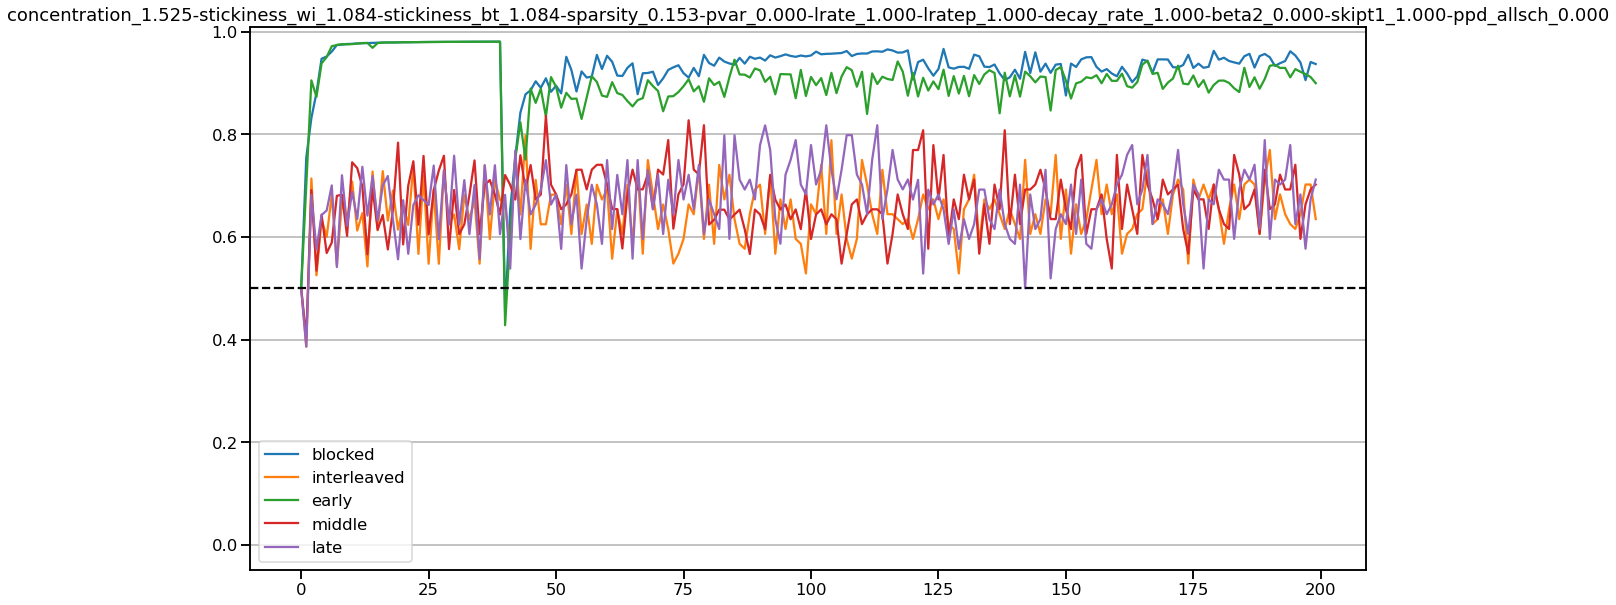

In [9]:
plt.figure(figsize=(20,10))
for idx in range(len(condL)):
  plt.plot(mean_acc[idx],label=condL[idx])
plt.legend()
plt.axhline(0.5,c='k',ls='--')
plt.ylim(-0.05,1.01)
plt.title(param_str)
plt.grid(True,axis='y')
plt.savefig(figdir+'acc-by-time.png')


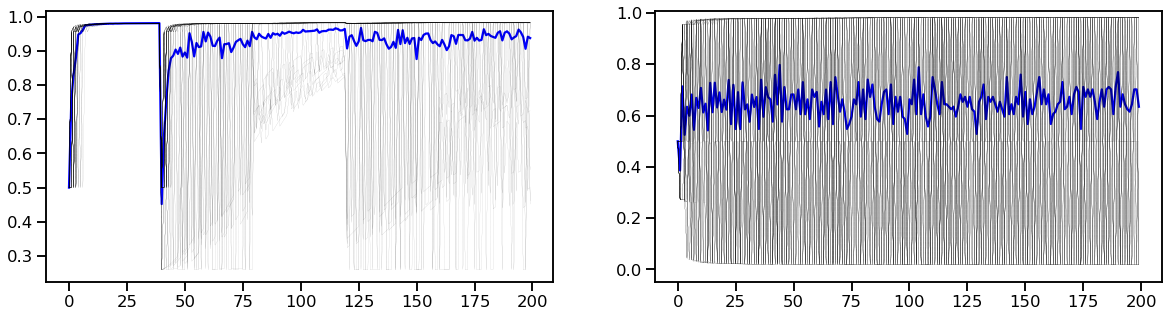

In [10]:
batch_acc.shape #curr,seeds,tsteps,trials
f,axar=plt.subplots(1,2,figsize=(20,5))
for cidx in range(2):
  ax= axar[cidx]
  _acc = batch_acc[cidx].mean(1)
  ax.plot(_acc.mean(0),c='b')
  for sacc in _acc:
    ax.plot(sacc,c='k',lw=.05)
    
plt.ylim(-0.05,1.01)
plt.savefig(figdir+'seed-acc-by-time-BI.png')

# infered schema

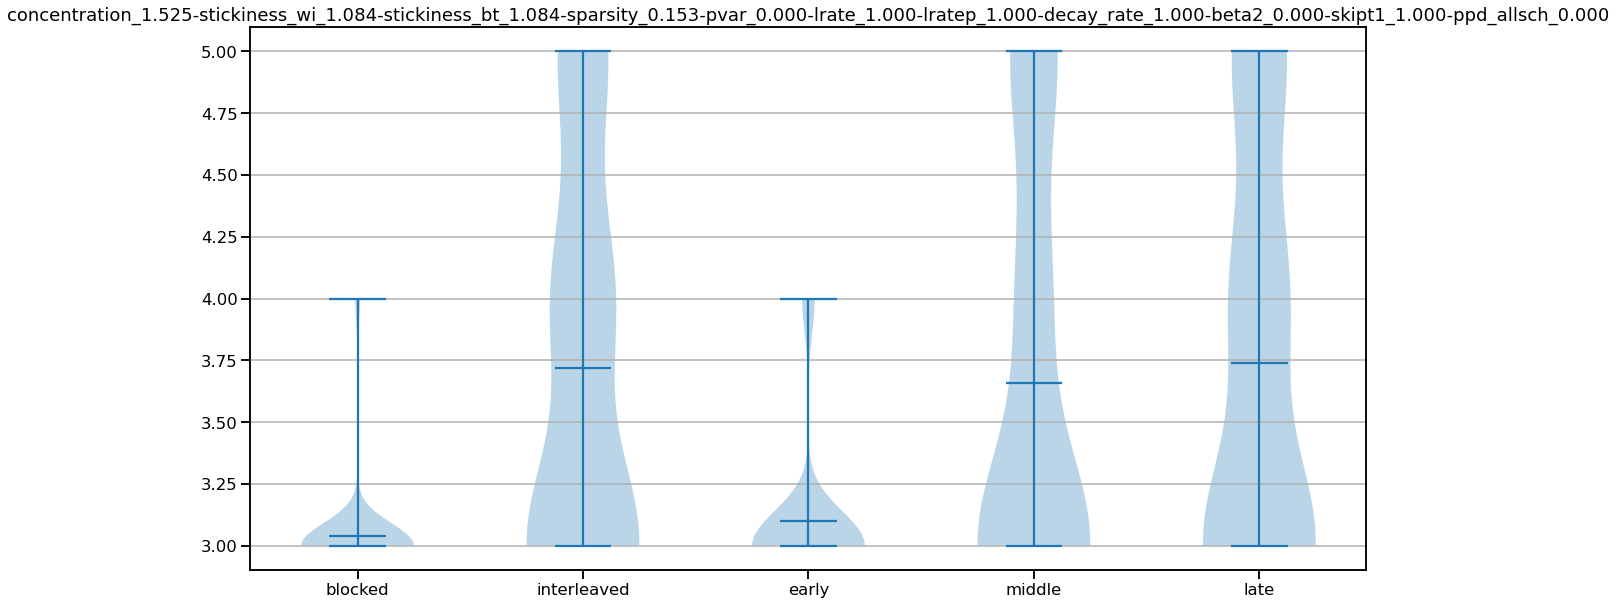

In [11]:
## count number of schemas used
def count_num_schemas(exp_data):
  """ 
  """
  L = []
  for curr_idx in range(len(condL)):
    num_schemas_used = [
      len(np.unique(exp_data[curr_idx][i]['zt'][:,:-1].flatten())
         ) for i in range(ns)
    ]
    L.append(num_schemas_used)
  nschemas = np.array(L)
  return nschemas


nschemas = count_num_schemas(exp_batch_data)
M = nschemas.mean(1)
S = nschemas.std(1)
plt.figure(figsize=(20,10))
plt.title('number schemas used')
plt.violinplot(nschemas.T,np.arange(len(condL)),showmeans=True)
# plt.bar(condL,M,zorder=-100,alpha=0.1)
ax = plt.gca()
ax.set_xticks(range(len(condL)))
ax.set_xticklabels(condL)
plt.grid(True,axis='y')
plt.title(param_str)
plt.savefig(figdir+'nsch-violin.png')

In [12]:
curr_idx = 0
seed_idx = 1
## 
prior = unpack_data(exp_batch_data,
        dtype='prior')[curr_idx][seed_idx]
like = unpack_data(exp_batch_data,
        dtype='like')[curr_idx][seed_idx]
post = unpack_data(exp_batch_data,
        dtype='post')[curr_idx][seed_idx]
post.shape

(200, 5, 3)

### adjusted rand score

In [13]:
def calc_adjrand(exp_batch_data):
  arscores = -np.ones([len(condL),ns,3])
  for curr_idx in range(len(condL)):
    for seed_idx in range(ns):
      for t_idx,tstep in enumerate([0,2,3]):
        arscores[curr_idx,seed_idx,t_idx] = adjusted_rand_score(
          exp_batch_data[curr_idx][seed_idx]['exp'][:,1],
          exp_batch_data[curr_idx][seed_idx]['zt'][:,tstep]
        )
  return arscores

arscores = calc_adjrand(exp_batch_data)

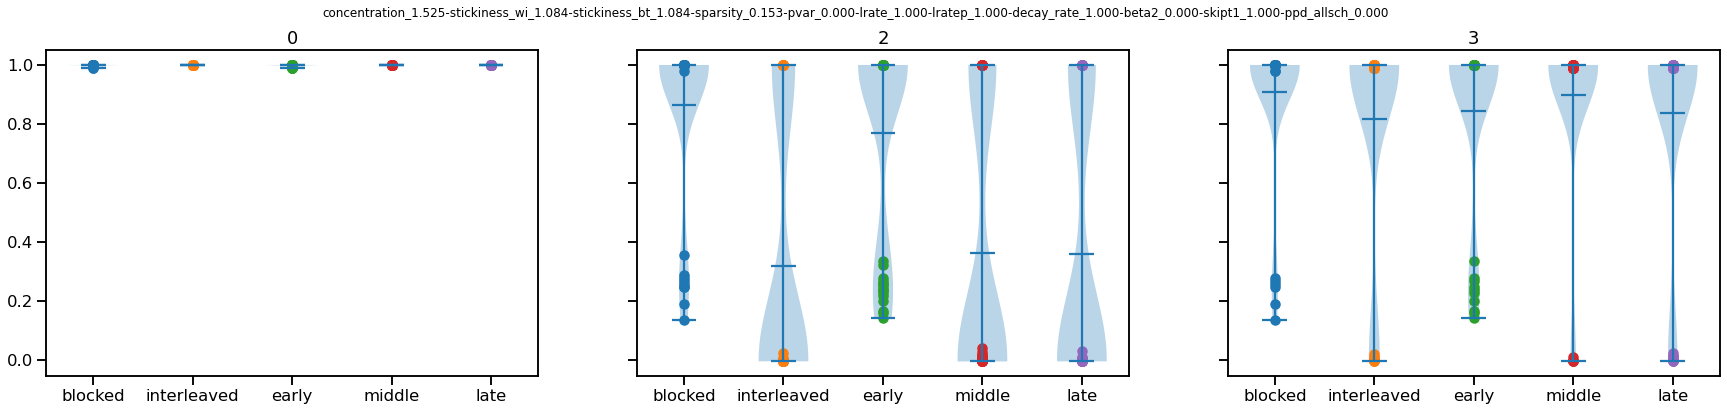

In [14]:
f,axar=plt.subplots(1,3,figsize=(30,6),sharey=True)
for t in range(3):
  ax=axar[t]
  ax.violinplot(arscores[:,:,t].T,showextrema=1,showmeans=1)
  for c in range(len(condL)):
    ax.scatter(np.repeat(c+1,ns),arscores[c,:,t].T)
  ax.set_xticks(np.arange(1,len(condL)+1))
  ax.set_xticklabels(condL)
  ax.set_title(['0','2','3'][t])
plt.suptitle(param_str)
plt.savefig(figdir+'adjrand')

In [15]:
curr = 0
for seed in range(20):
  print('seed',seed)
  zt = exp_batch_data[curr][seed]['zt']
  st = exp_batch_data[curr][seed]['exp']

  prior = unpack_data(exp_batch_data,
          dtype='prior')[curr][seed] # trial,tstep,sch
  like = unpack_data(exp_batch_data,
          dtype='like')[curr][seed]
  post = unpack_data(exp_batch_data,
          dtype='post')[curr][seed]
  xth = exp_batch_data[curr][seed]['xth'].argmax(-1)


  for i in np.arange(83):
#   for i in np.arange(100):
#   for i in np.arange(5):
    
    print("t%.2i"%i,'z_h=',zt[i],'st=',st[i],'xth=',xth[i]
  #        post[i,:,1],
  #        post[i,:,2]
         )

seed 0
t00 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 3 5 7] xth= [0 0 0 0 0]
t01 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t02 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 4 6 8] xth= [1 0 0 0 0]
t03 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t04 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t05 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t06 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t07 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t08 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t09 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t10 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t11 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t12 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t13 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t14 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t15 z_h= [ 0. -1.  0.  0. -1.] st

t06 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t07 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t08 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t09 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t10 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t11 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t12 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t13 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t14 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t15 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t16 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t17 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t18 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t19 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t20 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t21 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 

t57 z_h= [ 2. -1.  0.  2. -1.] st= [0 2 4 5 8] xth= [2 0 0 7 0]
t58 z_h= [ 2. -1.  2.  2. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t59 z_h= [ 2. -1.  2.  2. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t60 z_h= [ 2. -1.  0.  2. -1.] st= [0 2 4 5 8] xth= [2 0 0 7 0]
t61 z_h= [ 2. -1.  2.  2. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t62 z_h= [ 2. -1.  0.  2. -1.] st= [0 2 4 5 8] xth= [2 0 0 7 0]
t63 z_h= [ 2. -1.  0.  2. -1.] st= [0 2 4 5 8] xth= [2 0 0 7 0]
t64 z_h= [ 2. -1.  2.  2. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t65 z_h= [ 2. -1.  0.  2. -1.] st= [0 2 4 5 8] xth= [2 0 0 7 0]
t66 z_h= [ 2. -1.  0.  2. -1.] st= [0 2 4 5 8] xth= [2 0 0 7 0]
t67 z_h= [ 2. -1.  2.  2. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t68 z_h= [ 2. -1.  2.  2. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t69 z_h= [ 2. -1.  0.  2. -1.] st= [0 2 4 5 8] xth= [2 0 0 7 0]
t70 z_h= [ 2. -1.  0.  2. -1.] st= [0 2 4 5 8] xth= [2 0 0 7 0]
t71 z_h= [ 2. -1.  2.  2. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t72 z_h= [ 2. -1.  0.  2. -1.] st= [0 2 

t54 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t55 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t56 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t57 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 4 5 8] xth= [2 0 5 8 0]
t58 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t59 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t60 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 4 5 8] xth= [2 0 5 8 0]
t61 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t62 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t63 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t64 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t65 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t66 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t67 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 4 5 8] xth= [2 0 5 8 0]
t68 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 4 5 8] xth= [2 0 5 8 0]
t69 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 

t51 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 4 5 8] xth= [2 0 5 8 0]
t52 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t53 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t54 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t55 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 4 5 8] xth= [2 0 5 8 0]
t56 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 4 5 8] xth= [2 0 5 8 0]
t57 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 4 5 8] xth= [2 0 5 8 0]
t58 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 4 5 8] xth= [2 0 5 8 0]
t59 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 4 5 8] xth= [2 0 5 8 0]
t60 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 4 5 8] xth= [2 0 5 8 0]
t61 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 4 5 8] xth= [2 0 5 8 0]
t62 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 4 5 8] xth= [2 0 5 8 0]
t63 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 4 5 8] xth= [2 0 5 8 0]
t64 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 4 5 8] xth= [2 0 5 8 0]
t65 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t66 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 

t66 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 4 5 8] xth= [2 0 5 8 0]
t67 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t68 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t69 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t70 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 4 5 8] xth= [2 0 5 8 0]
t71 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t72 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 4 5 8] xth= [2 0 5 8 0]
t73 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t74 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 4 5 8] xth= [2 0 5 8 0]
t75 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 4 5 8] xth= [2 0 5 8 0]
t76 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t77 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t78 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 4 5 8] xth= [2 0 5 8 0]
t79 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 4 5 8] xth= [2 0 5 8 0]
t80 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 3 5 7] xth= [2 0 5 7 0]
t81 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 

t08 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t09 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t10 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t11 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t12 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t13 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t14 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t15 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t16 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t17 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t18 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t19 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t20 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t21 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t22 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t23 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 

t38 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t39 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t40 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 4 5 8] xth= [1 0 0 0 0]
t41 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 3 6 7] xth= [2 0 0 0 0]
t42 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t43 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t44 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 4 5 8] xth= [2 0 5 8 0]
t45 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 4 5 8] xth= [2 0 5 8 0]
t46 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 4 5 8] xth= [2 0 5 8 0]
t47 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t48 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t49 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t50 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t51 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 4 5 8] xth= [2 0 5 8 0]
t52 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 3 6 7] xth= [2 0 6 7 0]
t53 z_h= [ 1. -1.  1.  1. -1.] st= [0 2 

t00 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 4 6 8] xth= [0 0 0 0 0]
t01 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 3 5 7] xth= [1 0 0 0 0]
t02 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t03 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t04 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t05 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t06 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t07 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t08 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t09 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t10 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t11 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t12 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t13 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 3 5 7] xth= [1 0 5 7 0]
t14 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 4 6 8] xth= [1 0 6 8 0]
t15 z_h= [ 0. -1.  0.  0. -1.] st= [0 1 

# interleaved failure

In [18]:
### analysis of failed interleaved seeds
IseedAcc = batch_acc[1].mean(1) # seeds,trials
print(IseedAcc.shape)

(50, 200)


In [48]:
def compSuccess(seedAcc):
  return seedAcc[:,-50:].mean(1)>0.95
accSuccess = compSuccess(IseedAcc)
"N=%i seeds "%len(accSuccess), "high acc rate:", np.sum(accSuccess) / len(accSuccess)

('N=50 seeds ', 'high acc rate', 0.32)

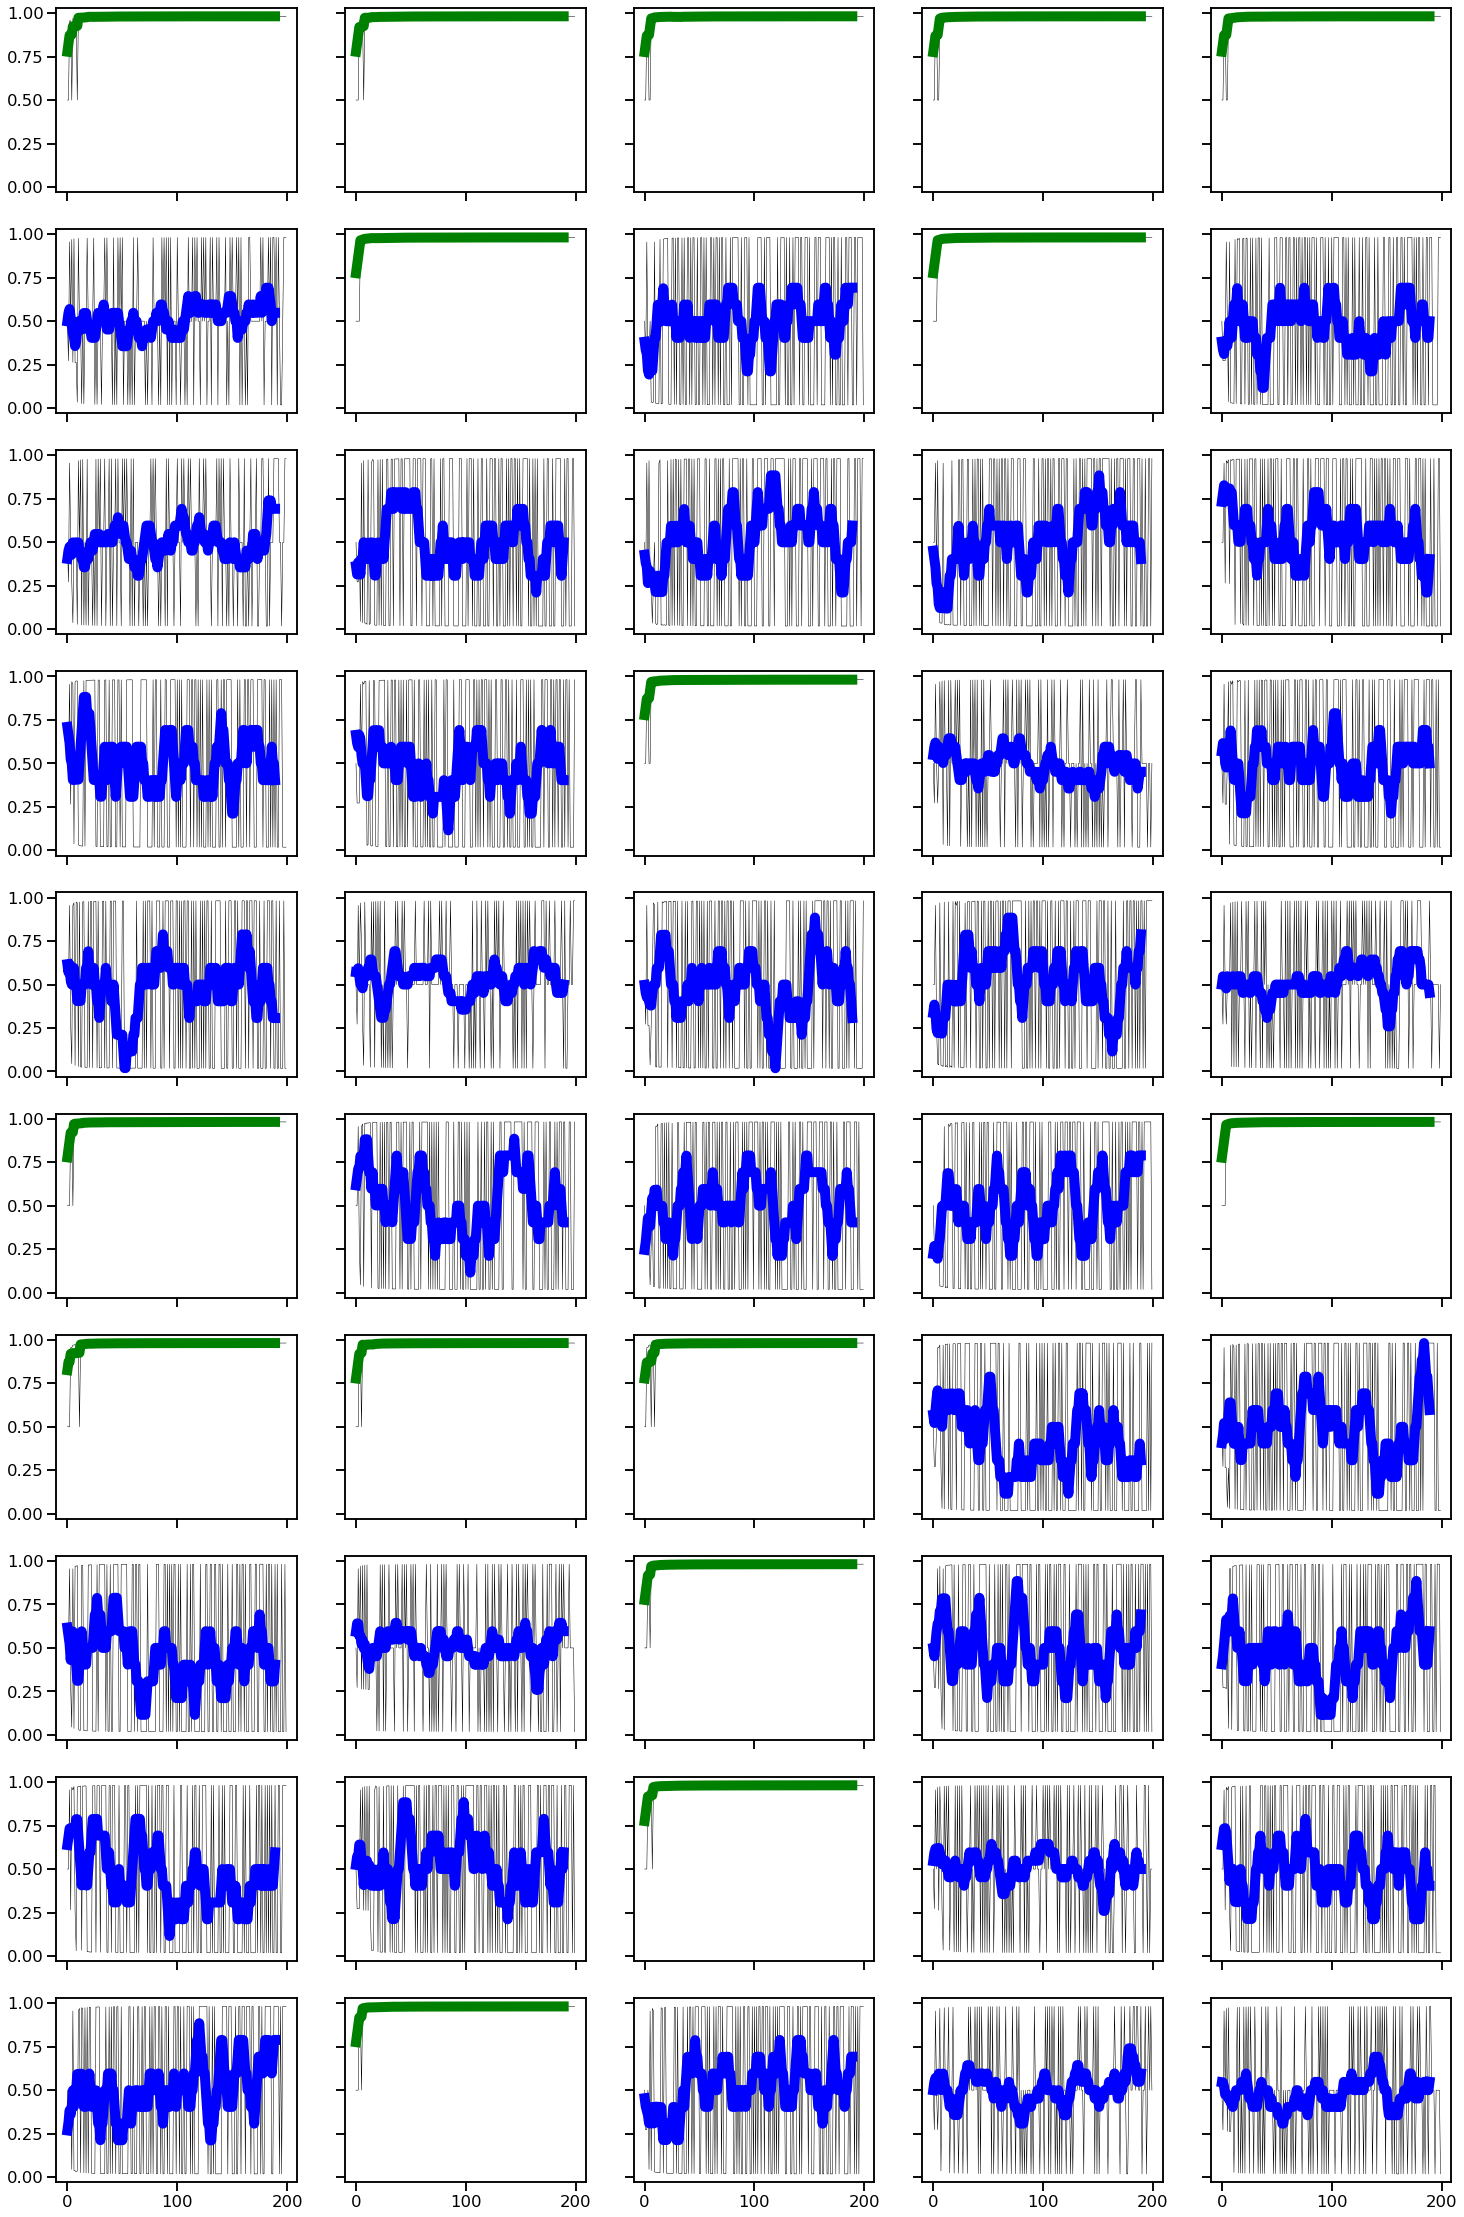

In [40]:
fg,axar = plt.subplots(10,5,figsize=(25,40),sharex=True,sharey=True);axar=axar.reshape(-1)
for si in range(len(IseedAcc)):
  ax=axar[si]
  sacc = IseedAcc[si]
  ax.plot(sacc,c='k',lw=.5)
  ax.plot(movavg(sacc,10),
          lw=10,c=['b','g'][accSuccess.astype(int)[si]]
         )
plt.savefig(figdir+'Iseed-acc.png')

In [17]:
assert False

AssertionError: 

# posterior, likelihood, prior
### analysis of model state

In [ ]:
def plt_prdata(dtype='post',schL=[0,1],curr_idx=0,seed_idx=0):
  """ 
  plots probability data (post,prior,like) 
  of at most 3 timesteps of 4 schemas
  NB single seed
  """
  # load data
  prdata = unpack_data(exp_batch_data,
          dtype=dtype)[curr_idx][seed_idx]
  # setup plots
  f,axar = plt.subplots(3,4,figsize=(20,10),sharex=True,sharey=True)
  # loop over timesteps and schema
  for ti,tstep in enumerate([0,2,3]):
    for si,sch in enumerate(schL):
      axar[0,si].set_title('sch%i'%sch)
      ax = axar[ti,si]
      # plot
      ax.plot(prdata[:,tstep,sch])
      for k in np.arange(0,200,40):
        ax.axvline(k,c='k',lw=0.5)
    axar[ti,0].set_ylabel('tstep%i'%tstep)
  title = '%s-%s'%(dtype,param_str)
  plt.suptitle(title)
  plt.savefig(figdir+'%s.png'%dtype)



In [ ]:
curr_idx=1
seed_idx=0
nsch = len(np.unique(exp_batch_data[curr_idx][seed_idx]['zt']))-1
print(nsch)
schL = [0,1]
plt_prdata('prior',schL,curr_idx,seed_idx)

In [ ]:
plt_prdata('post',schL,curr_idx,seed_idx)

In [ ]:
plt_prdata('like',schL,curr_idx,seed_idx)

# inspect splitting

In [ ]:
curr_idx,seed_idx=0,5
print('zt\n',exp_batch_data[curr_idx][seed_idx]['zt'][:3])
for k in ['post','prior','like']:
  print(k)
  print(exp_batch_data[curr_idx][seed_idx][k][:2,:,:5])
exp_batch_data[curr_idx][seed_idx][k].shape

# inspect prediction

In [ ]:
curr_idx,seed_idx=1,1
exp_batch_data[curr_idx][seed_idx]['xth'].argmax(-1)


In [ ]:
curr_idx,seed_idx=0,5
print('zt\n',exp_batch_data[curr_idx][seed_idx]['zt'][:3])
for k in ['xth']:
  print(k)
  print(exp_batch_data[curr_idx][seed_idx][k][:2,:,:5])
exp_batch_data[curr_idx][seed_idx][k].shape

In [ ]:
# def get_bad_seed(exp_batch_data,max_splits=10):
#   bad_seed_L = []
#   for curr_idx in range(5):
#     for seed_idx in range(ns):
#       max_sch = np.max(exp_batch_data[curr_idx][seed_idx]['zt'])
#       if max_sch>max_splits:
#         bad_seed_L.append(seed_idx)
#   return list(set(bad_seed_L))
# # get_bad_seed(exp_batch_data,max_splits=10)